## Problem Statement
You are working for a new-age insurance company and employ mutiple outreach plans to sell term insurance to your customers. Telephonic marketing campaigns still remain one of the most effective way to reach out to people however they incur a lot of cost. Hence, it is important to identify the customers that are most likely to convert beforehand so that they can be specifically targeted via call. We are given the historical marketing data of the insurance company and are required to build a ML model that will predict if a client will subscribe to the insurance.

## Features: 
age (numeric)<br>
job : type of job<br>
marital : marital status<br>
educational_qual : education status<br>
call_type : contact communication type<br>
day: last contact day of the month (numeric)<br>
mon: last contact month of year<br>
dur: last contact duration, in seconds (numeric)<br>
num_calls: number of contacts performed during this campaign and for this client <br>
prev_outcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")<br>

#### Output variable (desired target):<br>
y - has the client subscribed to the insurance?


## Imports

In [340]:
# Data manipution and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Cross Validation
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# Evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, RocCurveDisplay, classification_report

## Import the Dataset

In [341]:
df = pd.read_csv(r'D:\Data Science\Guvi\Final Project\dataset\train (2).csv')

In [342]:
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,unknown,unknown,5,may,92,1,unknown,no
4,33,unknown,single,unknown,unknown,5,may,198,1,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,cellular,17,nov,977,3,unknown,yes
45207,71,retired,divorced,primary,cellular,17,nov,456,2,unknown,yes
45208,72,retired,married,secondary,cellular,17,nov,1127,5,success,yes
45209,57,blue-collar,married,secondary,telephone,17,nov,508,4,unknown,no


In [343]:
df.shape

(45211, 11)

In [344]:
df.describe()

,age,day,dur,num_calls
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,15.806419,258.163080,2.763841
std,10.618762,8.322476,257.527812,3.098021
min,18.000000,1.000000,0.000000,1.000000
25%,33.000000,8.000000,103.000000,1.000000
50%,39.000000,16.000000,180.000000,2.000000
75%,48.000000,21.000000,319.000000,3.000000
max,95.000000,31.000000,4918.000000,63.000000


In [345]:
df['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [346]:
print('Not Subscribed - ', round(df['y'].value_counts()['no']/len(df)*100, 2), '% of the dataset')
print('Subscribed - ', round(df['y'].value_counts()['yes']/len(df)*100, 2), '% of the dataset')

Not Subscribed -  88.3 % of the dataset
Subscribed -  11.7 % of the dataset


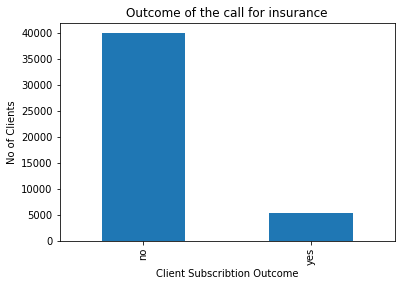

In [347]:
df['y'].value_counts().plot(kind='bar')
plt.title('Outcome of the call for insurance')
plt.xlabel('Client Subscribtion Outcome')
plt.ylabel('No of Clients')
plt.show()

We can see that the data is imbalanced, and resampling have to be used to train a model.

## Data Cleaning

In [348]:
# checking for null values
df.isnull().sum()

age               0
job               0
marital           0
education_qual    0
call_type         0
day               0
mon               0
dur               0
num_calls         0
prev_outcome      0
y                 0
dtype: int64

No null values in the data, but we can see there are 'unknown' category which we consider as null values.

In [349]:
df[df=='unknown'].count()

age                   0
job                 288
marital               0
education_qual     1857
call_type         13020
day                   0
mon                   0
dur                   0
num_calls             0
prev_outcome      36959
y                     0
dtype: int64

In [350]:
# Dropping the duplicate values
df.drop_duplicates(inplace=True)

In [351]:
df.shape

(45205, 11)

In [352]:
# Checking if all the columns are in right format
df.dtypes

age                int64
job               object
marital           object
education_qual    object
call_type         object
day                int64
mon               object
dur                int64
num_calls          int64
prev_outcome      object
y                 object
dtype: object

All Columns are in right format

### age Column

In [353]:
df['age'].unique()

array([58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 57, 51, 45, 60, 56, 32,
       25, 40, 39, 52, 46, 36, 49, 59, 37, 50, 54, 55, 48, 24, 38, 31, 30,
       27, 34, 23, 26, 61, 22, 21, 20, 66, 62, 83, 75, 67, 70, 65, 68, 64,
       69, 72, 71, 19, 76, 85, 63, 90, 82, 73, 74, 78, 80, 94, 79, 77, 86,
       95, 81, 18, 89, 84, 87, 92, 93, 88], dtype=int64)

### job Column

In [354]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'unknown', 'retired', 'admin.', 'services', 'self-employed',
       'unemployed', 'housemaid', 'student'], dtype=object)

In [355]:
# Count of unknown values
job_uc = df['job'][df['job']=='unknown'].count()
job_uc

288

In [356]:
job_ucp = (job_uc/len(df['job']))*100
print(f'{round(job_ucp, 2)}% of job column is unknown')

0.64% of job column is unknown


In [357]:
# Imputing job column
df['job'].replace('unknown', df['job'].mode()[0], inplace=True)

In [358]:
df['job'].unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

### marital Column

In [359]:
df.marital.unique()

array(['married', 'single', 'divorced'], dtype=object)

### educatioin_qual Column

In [360]:
df.education_qual.unique()

array(['tertiary', 'secondary', 'unknown', 'primary'], dtype=object)

In [361]:
eq_uc = df['education_qual'][df['education_qual']=='unknown'].count()
eq_uc

1857

In [362]:
eq_ucp = eq_uc/len(df['education_qual'])*100
print(f'{round(eq_ucp, 2)}% of education_qual column is unknown')

4.11% of education_qual column is unknown


In [363]:
# Imputing education_qual Column
df['education_qual'].replace('unknown', df['education_qual'].mode()[0], inplace=True)

In [364]:
df['education_qual'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

### call_type Column

In [365]:
df.call_type.unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [366]:
ct_uc = df['call_type'][df['call_type']=='unknown'].count()
ct_uc

13017

In [367]:
ct_ucp = ct_uc/len(df['call_type'])*100
print(f'{round(ct_ucp, 2)}% of unknown in call_type column')

28.8% of unknown in call_type column


In [368]:
df['call_type'].value_counts()

cellular     29282
unknown      13017
telephone     2906
Name: call_type, dtype: int64

### day Column

In [369]:
df['day'].unique()

array([ 5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 19, 20, 21, 23, 26, 27, 28,
       29, 30,  2,  3,  4, 11, 17, 18, 24, 25,  1, 10, 22, 31],
      dtype=int64)

### mon Column

In [370]:
df['mon'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

### dur Column

In [371]:
df['dur'].unique()

array([ 261,  151,   76, ..., 1298, 1246, 1556], dtype=int64)

### num_calls Column

In [372]:
df['num_calls'].unique()

array([ 1,  2,  3,  5,  4,  6,  7,  8,  9, 10, 11, 12, 13, 19, 14, 24, 16,
       32, 18, 22, 15, 17, 25, 21, 43, 51, 63, 41, 26, 28, 55, 50, 38, 23,
       20, 29, 31, 37, 30, 46, 27, 58, 33, 35, 34, 36, 39, 44],
      dtype=int64)

### prev_outcome Column

In [373]:
df['prev_outcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [374]:
po_uc = df['prev_outcome'][df['prev_outcome']=='unknown'].count()
po_uc

36953

In [375]:
po_ucp = po_uc/df['prev_outcome'].count()*100
print(f'{po_ucp}% of prev_outcome Column is unknown')

81.74538214799247% of prev_outcome Column is unknown


In [376]:
df['prev_outcome'].value_counts()

unknown    36953
failure     4901
other       1840
success     1511
Name: prev_outcome, dtype: int64

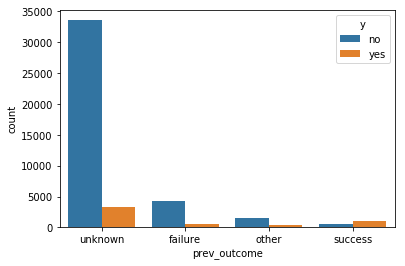

In [377]:
sns.countplot(df['prev_outcome'], hue=df['y'])

In [378]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,no
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,no
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,no
3,47,blue-collar,married,secondary,unknown,5,may,92,1,unknown,no
4,33,blue-collar,single,secondary,unknown,5,may,198,1,unknown,no


## Exploratory Data Analysis

In [379]:
# Putting column names in a list
columns = df.columns.to_list()
print(columns)

# Numerical Columns
num_col = df._get_numeric_data().columns.to_list()
print(num_col)

# Categorical Columns
cat_col = list(set(columns) - set(num_col))
print(cat_col)

['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon', 'dur', 'num_calls', 'prev_outcome', 'y']
['age', 'day', 'dur', 'num_calls']
['education_qual', 'marital', 'job', 'mon', 'call_type', 'prev_outcome', 'y']


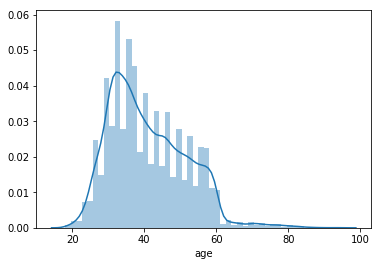

<Figure size 432x288 with 0 Axes>

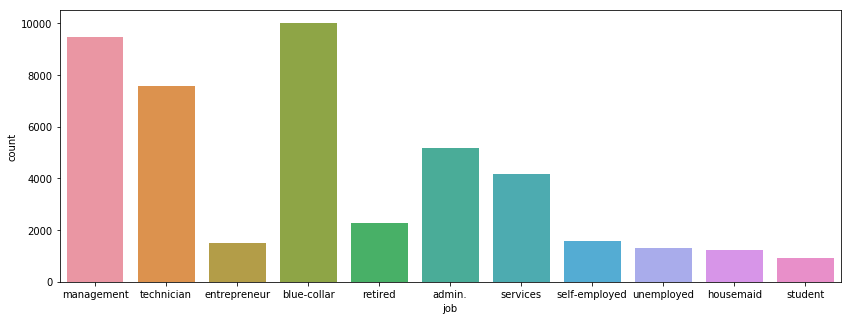

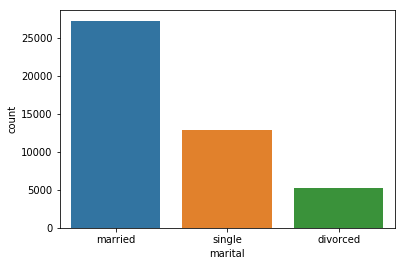

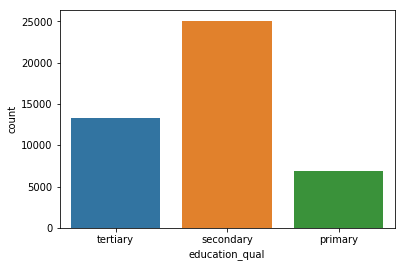

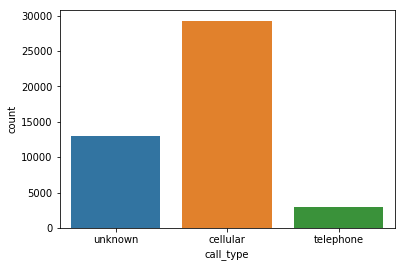

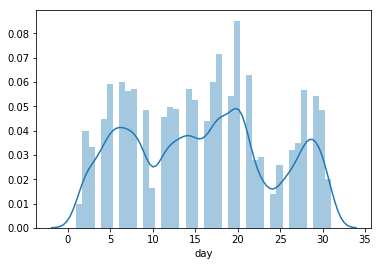

<Figure size 432x288 with 0 Axes>

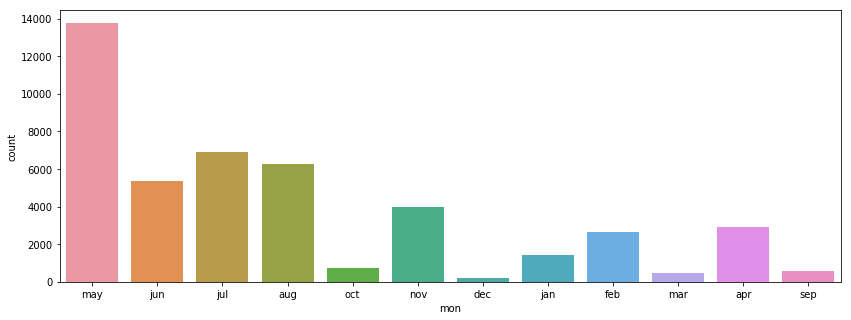

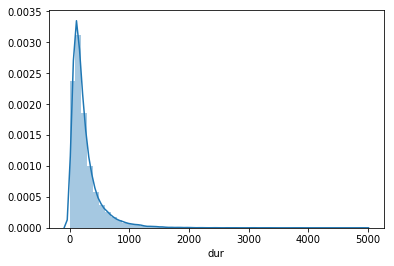

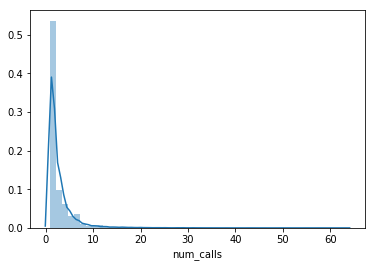

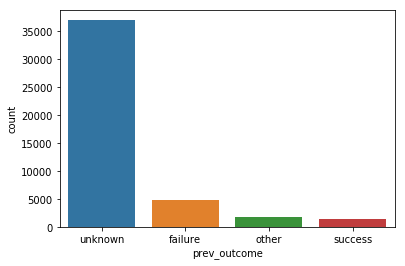

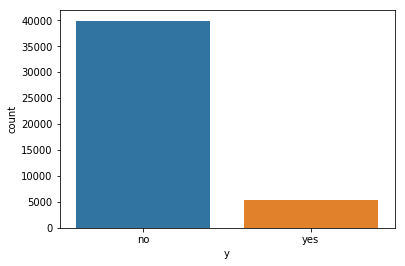

In [380]:
for i in columns:
    plt.figure()
    if i in num_col:
        sns.distplot(df[i])
    else:
        if i=='job' or i=='mon':
            plt.figure(figsize=(14, 5))
        sns.countplot(df[i])

**Observation:**
### What the insurance company doing:
- The age group of people from 30 to 40 are targeted for taking up insurance.
- Blue Collar and management people are targeted high.
- Married people are targeted high.
- Secondary Education people are targeted high.
- Cellular type calls are high.
- May month is the highly targeted month to sell insurance.
- The mean duration of the calls is 500 seconds.
- Number of calls per person is in the average of 4.

### independant features Vs The Target

In [381]:
df['y'] = df['y'].map({'yes':1, 'no':0})

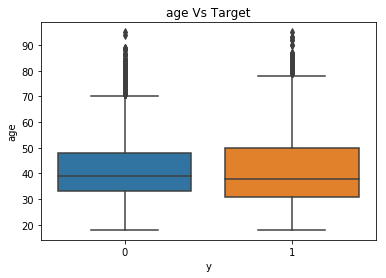

<Figure size 432x288 with 0 Axes>

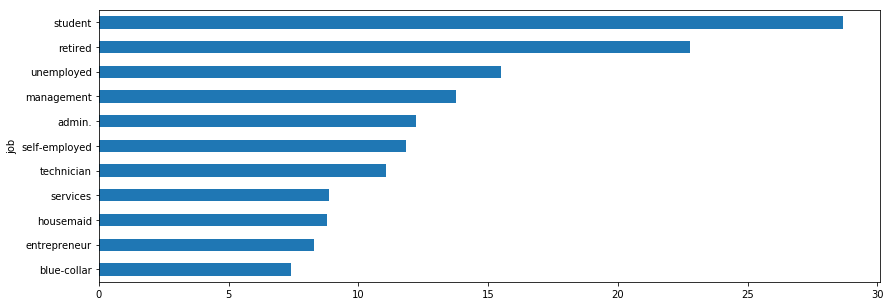

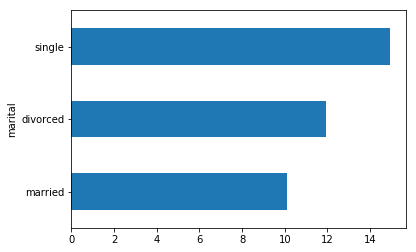

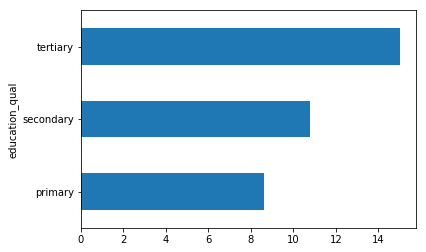

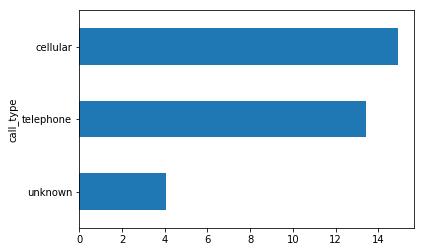

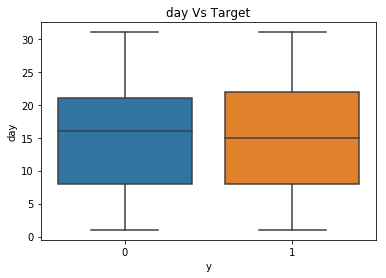

<Figure size 432x288 with 0 Axes>

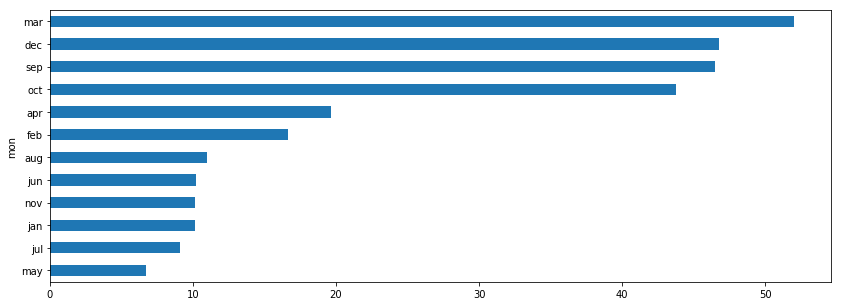

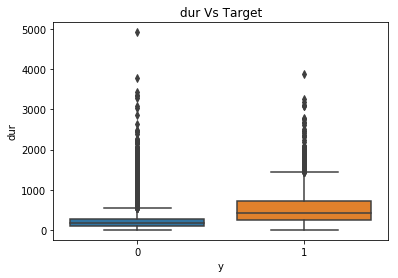

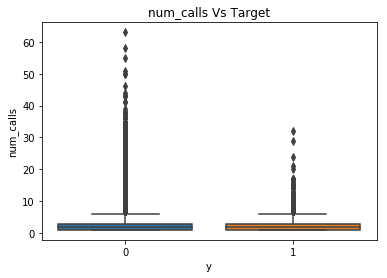

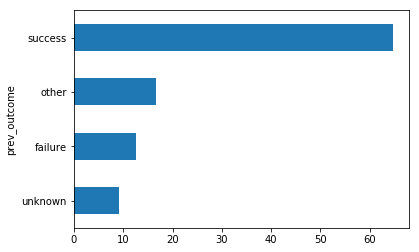

In [382]:
for i in range(10):
    plt.figure()
    if columns[i] in num_col:
        sns.boxplot(df['y'], df[columns[i]])
        plt.title(f'{columns[i]} Vs Target')
    else:
        if columns[i]=='job'or columns[i]=='mon':
            plt.figure(figsize=(14,5))
        (df.groupby(columns[i])['y'].mean()*100).sort_values().plot(kind='barh')

**Observation:**<br>
### What the insights telling:
- The people who are more likely to accept the insurance are in the job position --> Student, Retired and Management.
- Marital Status --> Single are more likely to accept the insurance.
- Customers with Tertiary Education Qualification has more chance to accept the insurance.
- Mar, Dec, Sep are the months where more percentage of people accept the insurance.
- The Duration of the call with 500 seconds are more convincable to the customers. And the Calls with so long duration and so less duration would not able to convince the customer.
- If the previous outcome is a success, there is a very high chance, that the customer is gonna accept the insurance.

**Observation:**
### What must insurance company do to reduce loss:
- The blue collars are the one who are targeted high by the company, but students are more likely to convert. So the insurance company must target students more.
- Single people must be targeted more than the married people.
- People with tertiary education is more likely to accept to the insurance. So company should target tertiary educated people more than secondary education people.
- The calls made by the company are more in the month may, but people are highly accepting the insurance in the months March, December and September. Therefore, the company should try more calls in these months.
- The mean Duration of 500 seconds is the right choice of duration to convert a customer.
- The one with previous outcome has success must be called.

## Encoding

In [383]:
df.head()

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,management,married,tertiary,unknown,5,may,261,1,unknown,0
1,44,technician,single,secondary,unknown,5,may,151,1,unknown,0
2,33,entrepreneur,married,secondary,unknown,5,may,76,1,unknown,0
3,47,blue-collar,married,secondary,unknown,5,may,92,1,unknown,0
4,33,blue-collar,single,secondary,unknown,5,may,198,1,unknown,0


### age Column Encoding

The age column is a continuous value and in the right encoding.

### job Column Encoding

In [384]:
df.job.unique()

array(['management', 'technician', 'entrepreneur', 'blue-collar',
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

Considering the job column as an ordinal data because the insurance acceptance correlates with the job of the person.

#### Doing an target guided ordinal encoding to job Column
The order is by the percentage of acceptance of the customers

In [385]:
job_cat_ord = {'blue-collar':1, 'entrepreneur':2, 'housemaid':3, 'services':4, 'technician': 5, 'self-employed':6,
              'admin.':7, 'management':8, 'unemployed':9, 'retired':10, 'student':11}
df['job'] = df['job'].map(job_cat_ord)

In [386]:
job_keys = job_cat_ord.keys()
print(sorted(list(job_keys)))

['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed']


In [387]:
# Checking if any spelling mistake when doing encoding
df['job'].unique()

array([ 8,  5,  2,  1, 10,  7,  4,  6,  9,  3, 11], dtype=int64)

### marital Column Encoding

In [388]:
df['marital'].unique()

array(['married', 'single', 'divorced'], dtype=object)

#### Doing an ordinal encoding

In [389]:
marital_cat_ord = {'married':1, 'divorced':2, 'single':3}
df['marital'] = df['marital'].map(marital_cat_ord)

In [390]:
df['marital'].unique()

array([1, 3, 2], dtype=int64)

### education_qual Column Encoding

In [391]:
df['education_qual'].unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

#### Doing an ordinal encoding

In [392]:
education_qual_cat_ord = {'primary':1, 'secondary':2, 'tertiary':3}
df['education_qual'] = df['education_qual'].map(education_qual_cat_ord)

In [393]:
df['education_qual'].unique()

array([3, 2, 1], dtype=int64)

### call_type Column Encoding

In [394]:
df['call_type'].unique()

array(['unknown', 'cellular', 'telephone'], dtype=object)

In [395]:
call_type_cat_ord = {'unknown':1, 'telephone':2, 'cellular':3}
df['call_type'] = df['call_type'].map(call_type_cat_ord)

In [396]:
df['call_type'].unique()

array([1, 3, 2], dtype=int64)

### mon Column Encoding

In [397]:
df['mon'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'jan', 'feb',
       'mar', 'apr', 'sep'], dtype=object)

#### Doing an target guided ordinal encoding to mon Column as the insurance acceptance correlates with what month the insurance call is made.

In [398]:
mon_cat_ord = {'may':1, 'jul':2, 'jan':3, 'nov':4, 'jun':5, 'aug':6, 'feb':7, 'apr':8, 'oct':9, 'sep':10, 'dec':11, 'mar':12}
df['mon'] = df['mon'].map(mon_cat_ord)

In [399]:
df['mon'].unique()

array([ 1,  5,  2,  6,  9,  4, 11,  3,  7, 12,  8, 10], dtype=int64)

### prev_outcome Column Encoding

In [400]:
df['prev_outcome'].unique()

array(['unknown', 'failure', 'other', 'success'], dtype=object)

In [401]:
prev_outcome_cat_ord = {'unknown':1, 'failure':2, 'other':3, 'success':4}
df['prev_outcome'] = df['prev_outcome'].map(prev_outcome_cat_ord)

In [402]:
df['prev_outcome'].unique()

array([1, 2, 3, 4], dtype=int64)

In [403]:
## Encoded Data
df

,age,job,marital,education_qual,call_type,day,mon,dur,num_calls,prev_outcome,y
0,58,8,1,3,1,5,1,261,1,1,0
1,44,5,3,2,1,5,1,151,1,1,0
2,33,2,1,2,1,5,1,76,1,1,0
3,47,1,1,2,1,5,1,92,1,1,0
4,33,1,3,2,1,5,1,198,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
45206,51,5,1,3,3,17,4,977,3,1,1
45207,71,10,2,1,3,17,4,456,2,1,1
45208,72,10,1,2,3,17,4,1127,5,4,1
45209,57,1,1,2,2,17,4,508,4,1,0


## Feature Selection

In [404]:
# dt = DecisionTreeClassifier()
# dt.fit(df.drop('y', axis=1), df['y'])

In [405]:
# imp_fea = dt.feature_importances_
# imp_df = pd.DataFrame({'Features': pd.DataFrame(df.drop('y', axis=1)).columns, 'Importance':imp_fea})
# imp_df.set_index('Importance')
# imp_df = imp_df.sort_values('Importance', ascending=False)
# imp_df.plot.bar()

In [406]:
# df.head()

In [407]:
# df.drop(['marital', 'education_qual', 'call_type'], axis=1, inplace=True)

In [408]:
# df.head()

## Splitting

In [409]:
X = df.drop('y', axis=1).values
y = df['y']

In [410]:
X

array([[  58,    8,    1, ...,  261,    1,    1],
       [  44,    5,    3, ...,  151,    1,    1],
       [  33,    2,    1, ...,   76,    1,    1],
       ...,
       [  72,   10,    1, ..., 1127,    5,    4],
       [  57,    1,    1, ...,  508,    4,    1],
       [  37,    2,    1, ...,  361,    2,    3]], dtype=int64)

In [411]:
y

0        0
1        0
2        0
3        0
4        0
        ..
45206    1
45207    1
45208    1
45209    0
45210    0
Name: y, Length: 45205, dtype: int64

In [510]:
from sklearn.model_selection import train_test_split
X_train, X_testbs, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.25)

In [511]:
print(y_train.value_counts()[0]/len(y_train))
print(y_train.value_counts()[1]/len(y_train))

0.8829897059257293
0.11701029407427072


In [512]:
print(y_test.value_counts()[0]/len(y_test))
print(y_test.value_counts()[1]/len(y_test))

0.8830295522916298
0.1169704477083702


## Balancing of Data

In [513]:
from imblearn.combine import SMOTEENN
smt = SMOTEENN(sampling_strategy='all')
X_smtbs, y_smt = smt.fit_resample(X_train, y_train)

In [514]:
X_smtbs

array([[ 50,   8,   1, ...,  62,   2,   1],
       [ 30,  11,   3, ..., 133,   5,   3],
       [ 35,   5,   1, ..., 196,   3,   2],
       ...,
       [ 60,   6,   1, ..., 920,   5,   1],
       [ 30,   6,   1, ...,  81,   1,   1],
       [ 37,   5,   1, ..., 107,   1,   3]], dtype=int64)

In [515]:
y_smt = y_smt.values

In [516]:
y_smt

array([0, 0, 0, ..., 1, 1, 1], dtype=int64)

In [517]:
X_smtbs = pd.DataFrame(X_smtbs)

In [519]:
X_smtbs.shape

(50449, 10)

In [520]:
y_smt.shape

(50449,)

In [521]:
pd.DataFrame(y_smt).value_counts()

1    28393
0    22056
dtype: int64

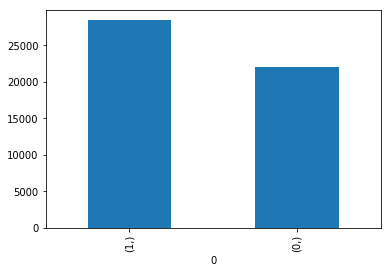

In [522]:
pd.DataFrame(y_smt).value_counts().plot(kind='bar')

In [424]:
X_smtbs.describe()

,0,1,2,3,4,5,6,7,8,9
count,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000,50371.000000
mean,40.857358,5.470410,1.644915,2.071887,2.469417,15.504080,4.295547,376.725755,2.367414,1.417780
std,11.529576,2.810269,0.843254,0.619879,0.808256,8.182687,2.827055,355.424324,2.662303,0.821735
min,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,32.000000,4.000000,1.000000,2.000000,2.000000,9.000000,2.000000,135.000000,1.000000,1.000000
50%,38.000000,6.000000,1.000000,2.000000,3.000000,15.000000,4.000000,251.000000,2.000000,1.000000
75%,49.000000,8.000000,2.000000,2.000000,3.000000,21.000000,6.000000,509.000000,3.000000,1.000000
max,95.000000,11.000000,3.000000,3.000000,3.000000,31.000000,12.000000,4918.000000,58.000000,4.000000


## Outlier Detection

### age Column

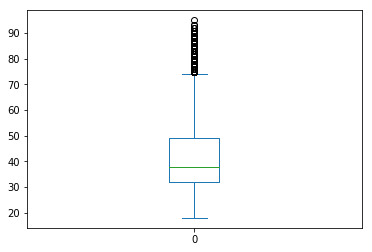

In [523]:
X_smtbs.iloc[:, 0].plot(kind='box')

In [524]:
iqr = X_smtbs[X_smtbs.columns[0]].quantile(0.75) - X_smtbs[X_smtbs.columns[0]].quantile(0.25)
upper_threshold = X_smtbs[X_smtbs.columns[0]].quantile(0.75) + (1.5 * iqr)
lower_threshold = X_smtbs[X_smtbs.columns[0]].quantile(0.25) - (1.5 * iqr)
print(lower_threshold)
print(upper_threshold)

6.5
74.5


The outliers are there in age column as maximum age is 95 and should be treated.

In [525]:
X_smtbs[0].clip(lower_threshold, upper_threshold, inplace=True)

In [526]:
X_smtbs[0].max()

74.5

### dur Column

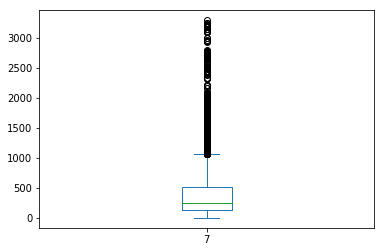

In [527]:
X_smtbs.iloc[:, 7].plot(kind='box')

In [528]:
iqr = X_smtbs[X_smtbs.columns[7]].quantile(0.75) - X_smtbs[X_smtbs.columns[7]].quantile(0.25)
upper_threshold = X_smtbs[X_smtbs.columns[7]].quantile(0.75) + (1.5 * iqr)
lower_threshold = X_smtbs[X_smtbs.columns[7]].quantile(0.25) - (1.5 * iqr)
print(lower_threshold)
print(upper_threshold)

-423.5
1068.5


In [529]:
X_smtbs[7].max()

3298

In [530]:
X_smtbs[7].clip(lower_threshold, upper_threshold, inplace=True)

In [531]:
X_smtbs[7].max()

1068.5

In [532]:
X_smtbs = X_smtbs.values

In [533]:
X_smtbs

array([[ 50.,   8.,   1., ...,  62.,   2.,   1.],
       [ 30.,  11.,   3., ..., 133.,   5.,   3.],
       [ 35.,   5.,   1., ..., 196.,   3.,   2.],
       ...,
       [ 60.,   6.,   1., ..., 920.,   5.,   1.],
       [ 30.,   6.,   1., ...,  81.,   1.,   1.],
       [ 37.,   5.,   1., ..., 107.,   1.,   3.]])

## Scaling

In [534]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_smt = sc.fit_transform(X_smtbs)
X_test = sc.transform(X_testbs)

In [535]:
X_smt

array([[ 0.78154577,  0.8936069 , -0.75663913, ..., -1.00140248,
        -0.13532613, -0.50272017],
       [-0.959085  ,  1.95739519,  1.61796039, ..., -0.76286016,
         0.98952033,  1.9626954 ],
       [-0.52392731, -0.17018138, -0.75663913, ..., -0.55119585,
         0.23962269,  0.72998761],
       ...,
       [ 1.65186115,  0.18441471, -0.75663913, ...,  1.88126384,
         0.98952033, -0.50272017],
       [-0.959085  ,  0.18441471, -0.75663913, ..., -0.93756721,
        -0.51027495, -0.50272017],
       [-0.34986423, -0.17018138, -0.75663913, ..., -0.85021369,
        -0.51027495,  1.9626954 ]])

In [536]:
X_test

array([[ 0.43341961, -1.58856577, -0.75663913, ..., -0.77629917,
         0.23962269, -0.50272017],
       [ 1.47779807, -0.17018138, -0.75663913, ..., -0.94764646,
        -0.13532613, -0.50272017],
       [ 0.60748269, -0.52477748,  1.61796039, ...,  0.16779085,
        -0.13532613,  0.72998761],
       ...,
       [ 1.47779807, -0.17018138, -0.75663913, ..., -0.80989667,
         1.36446915, -0.50272017],
       [ 0.69451423,  0.53901081, -0.75663913, ...,  0.665034  ,
        -0.51027495, -0.50272017],
       [-0.26283269, -1.58856577, -0.75663913, ...,  0.88677756,
        -0.51027495, -0.50272017]])

## Model

### Logistic Regression

In [537]:
lr = LogisticRegression()
lr.fit(X_smt, y_smt)

LogisticRegression()

In [538]:
print(confusion_matrix(y_test, lr.predict(X_test)))

[[7326 2654]
 [ 172 1150]]


In [539]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.8816948571879007

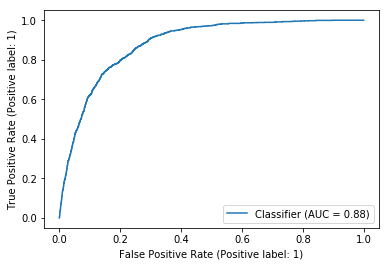

In [540]:
RocCurveDisplay.from_predictions(y_test, lr.predict_proba(X_test)[:, 1])

In [541]:
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.73      0.98      0.84      7498
           1       0.87      0.30      0.45      3804

    accuracy                           0.75     11302
   macro avg       0.80      0.64      0.64     11302
weighted avg       0.78      0.75      0.71     11302



### K - Nearest Neighbors

In [104]:
knn = KNeighborsClassifier()
k_range = range(1, 21)
train_scores = []
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_smt, y_smt)
    train_score = roc_auc_score(y_smt, knn.predict_proba(X_smt)[:, 1])
    val_score = np.mean(cross_val_score(knn, X_smt, y_smt, cv=5, scoring='roc_auc'))
    k_score = val_score
    print(f'K = {k}----Train Score = {train_score}----CV Score = {k_score}')

K = 1----Train Score = 1.0----CV Score = 0.9361230161165256
K = 2----Train Score = 0.9986074952782675----CV Score = 0.9571427264068653
K = 3----Train Score = 0.9969847785303757----CV Score = 0.9636239320480586
K = 4----Train Score = 0.9953422504396072----CV Score = 0.967335100496187
K = 5----Train Score = 0.9937074853097432----CV Score = 0.9692118115839092
K = 6----Train Score = 0.9921793454240257----CV Score = 0.9703322159380253
K = 7----Train Score = 0.9907935965892467----CV Score = 0.9708969608519957
K = 8----Train Score = 0.9894508297341801----CV Score = 0.9712134096042565
K = 9----Train Score = 0.988293767633099----CV Score = 0.9716613458735086
K = 10----Train Score = 0.9872063412435784----CV Score = 0.9716245737199541
K = 11----Train Score = 0.9863534376963725----CV Score = 0.9716910645109158
K = 12----Train Score = 0.9854589560416522----CV Score = 0.9719019191210929
K = 13----Train Score = 0.9847020602110992----CV Score = 0.9718079339324774
K = 14----Train Score = 0.983976475730

In [105]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_smt, y_smt)

KNeighborsClassifier(n_neighbors=11)

In [106]:
print(confusion_matrix(y_test, knn.predict(X_test)))

[[7814 2166]
 [ 187 1135]]


In [107]:
roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])

0.8832828288953096

In [108]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9980
           1       0.34      0.86      0.49      1322

    accuracy                           0.79     11302
   macro avg       0.66      0.82      0.68     11302
weighted avg       0.90      0.79      0.82     11302



### Decision Tree

In [109]:
dt = DecisionTreeClassifier()
for depth in [5,6,7,8,9,10,11,12,13,14,15,20,30,40]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_smt, y_smt)
    train_score = roc_auc_score(y_smt, dt.predict(X_smt))
    dt = DecisionTreeClassifier(max_depth=depth)
    val_score = np.mean(cross_val_score(dt, X_smt, y_smt, cv=10, scoring='roc_auc'))
    print("Depth  : ", depth, " Training Accuracy : ", train_score, " Cross val score : " ,val_score)

Depth  :  5  Training Accuracy :  0.8765959165974907  Cross val score :  0.9432015007840284
Depth  :  6  Training Accuracy :  0.8843932418173304  Cross val score :  0.9509996839910888
Depth  :  7  Training Accuracy :  0.9052198398310861  Cross val score :  0.957802452715125
Depth  :  8  Training Accuracy :  0.9177081313861722  Cross val score :  0.9644398339336023
Depth  :  9  Training Accuracy :  0.926488024297182  Cross val score :  0.9667550189082761
Depth  :  10  Training Accuracy :  0.9350904817296739  Cross val score :  0.9678309039920654
Depth  :  11  Training Accuracy :  0.9435254061807004  Cross val score :  0.9672535219169012
Depth  :  12  Training Accuracy :  0.9569463926488865  Cross val score :  0.9663521580365233
Depth  :  13  Training Accuracy :  0.9640828583243002  Cross val score :  0.9653212938976804
Depth  :  14  Training Accuracy :  0.9721352184750355  Cross val score :  0.9617133942056112
Depth  :  15  Training Accuracy :  0.9786368752045355  Cross val score :  0.9

In [110]:
dt = DecisionTreeClassifier(max_depth=11)
dt.fit(X_smt, y_smt)

DecisionTreeClassifier(max_depth=11)

In [111]:
print(confusion_matrix(y_test, dt.predict(X_test)))

[[7640 2340]
 [ 175 1147]]


In [112]:
roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

0.8542960732357301

In [113]:
print(classification_report(y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      9980
           1       0.33      0.87      0.48      1322

    accuracy                           0.78     11302
   macro avg       0.65      0.82      0.67     11302
weighted avg       0.90      0.78      0.81     11302



### Voting Classifier

In [114]:
from sklearn.ensemble import VotingClassifier
vc = VotingClassifier(estimators=[('lr', lr), ('dt', dt),('knn', knn)], voting='soft')
vc.fit(X_smt, y_smt)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('dt', DecisionTreeClassifier(max_depth=11)),
                             ('knn', KNeighborsClassifier(n_neighbors=11))],
                 voting='soft')

In [115]:
print(confusion_matrix(y_test, vc.predict(X_test)))

[[7811 2169]
 [ 141 1181]]


In [116]:
roc_auc_score(y_test, vc.predict_proba(X_test)[:,1])

0.8990992575165458

In [117]:
print(classification_report(y_test, vc.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.78      0.87      9980
           1       0.35      0.89      0.51      1322

    accuracy                           0.80     11302
   macro avg       0.67      0.84      0.69     11302
weighted avg       0.91      0.80      0.83     11302



### Random Forest

In [118]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [10, 100, 500],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4, 5]
}

random_search = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 5, n_jobs = 8, verbose = 2)
random_search.fit(X_smt, y_smt)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=8,
                   param_distributions={'min_samples_leaf': [2, 3, 4, 5],
                                        'min_samples_split': [2, 3, 4],
                                        'n_estimators': [10, 100, 500]},
                   verbose=2)

In [119]:
random_search.best_estimator_

RandomForestClassifier(min_samples_leaf=2, min_samples_split=3)

In [120]:
for depth in range(30, 41):
    rf = RandomForestClassifier(max_depth=depth, n_estimators=500, min_samples_split=3, min_samples_leaf=2)
    rf.fit(X_smt, y_smt)
    train_score = roc_auc_score(y_smt, rf.predict(X_smt))
    rf = RandomForestClassifier(max_depth=depth)
    val_score = np.mean(cross_val_score(rf, X_smt, y_smt, cv=10, scoring='roc_auc'))
    print("Depth  : ", depth, " Training Accuracy : ", train_score, " Cross val score : " ,val_score)

Depth  :  30  Training Accuracy :  0.9913098152366736  Cross val score :  0.9951160937514706
Depth  :  31  Training Accuracy :  0.9911085686889495  Cross val score :  0.9949042912344656
Depth  :  32  Training Accuracy :  0.991339826675288  Cross val score :  0.9950367681518314
Depth  :  33  Training Accuracy :  0.9911690304250388  Cross val score :  0.9951255036734121
Depth  :  34  Training Accuracy :  0.9912821218934186  Cross val score :  0.9950970917529496
Depth  :  35  Training Accuracy :  0.9913823063084196  Cross val score :  0.9949918914212639
Depth  :  36  Training Accuracy :  0.9913901383122189  Cross val score :  0.9951663923803602
Depth  :  37  Training Accuracy :  0.9912142670123908  Cross val score :  0.9950776285597304
Depth  :  38  Training Accuracy :  0.9912618216951016  Cross val score :  0.9950822607213707
Depth  :  39  Training Accuracy :  0.9914353748995708  Cross val score :  0.9949609648965844
Depth  :  40  Training Accuracy :  0.9916864942253649  Cross val score 

In [121]:
rf = RandomForestClassifier(max_depth=36, n_estimators=500, min_samples_split=3, min_samples_leaf=2)
rf.fit(X_smt, y_smt)

RandomForestClassifier(max_depth=36, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=500)

In [122]:
print(confusion_matrix(y_test, rf.predict(X_test)))

[[8134 1846]
 [ 147 1175]]


In [123]:
print(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

0.9102725875351307


In [124]:
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      9980
           1       0.39      0.89      0.54      1322

    accuracy                           0.82     11302
   macro avg       0.69      0.85      0.72     11302
weighted avg       0.91      0.82      0.85     11302



### XG Boost

In [125]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7]
}

#### Randomized Search

In [126]:
xgb = XGBClassifier()
random_search = RandomizedSearchCV(xgb, param_distributions=param_grid, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=3)
random_search.fit(X_smt, y_smt)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=Non

In [127]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=8, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [128]:
random_search.best_params_

{'min_child_weight': 3,
 'max_depth': 8,
 'learning_rate': 0.6,
 'gamma': 0.1,
 'colsample_bytree': 0.7}

#### Bayes Search

In [129]:
xgb = XGBClassifier()
bayes_search = BayesSearchCV(xgb, search_spaces=param_grid, n_iter=5, scoring='roc_auc', n_jobs=-1, cv=10, verbose=3)
bayes_search.fit(X_smt, y_smt)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


BayesSearchCV(cv=10,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=None, gpu_id=None,
                                      grow_policy=None, importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_bin=None,
                                      max_...
                                      n_estimators=100, n_jobs=None,
                                      num_parallel_tree=None, predictor=None,
                                      random_state=None, reg_alpha=None,
               

In [130]:
bayes_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.6, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [131]:
bayes_search.best_params_

OrderedDict([('colsample_bytree', 0.4),
             ('gamma', 0.3),
             ('learning_rate', 0.6),
             ('max_depth', 12),
             ('min_child_weight', 5)])

#### XGBoost Training

In [132]:
{'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

{'min_child_weight': 1,
 'max_depth': 12,
 'learning_rate': 1,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [542]:
xgb = XGBClassifier(min_child_weight=15,
 max_depth=12,
 learning_rate=0.5,
 gamma=0.2,
 colsample_bytree=0.4)
xgb.fit(X_smt, y_smt)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=15,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [543]:
print(confusion_matrix(y_test, xgb.predict(X_test)))

[[8350 1630]
 [ 194 1128]]


In [544]:
roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])

0.9144834676918133

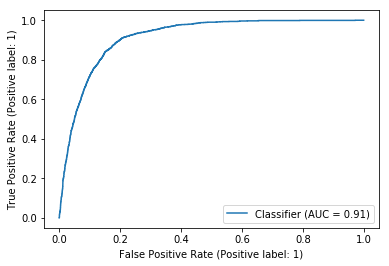

In [545]:
RocCurveDisplay.from_predictions(y_test, xgb.predict_proba(X_test)[:, 1])

In [546]:
print(classification_report(y_test, xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      9980
           1       0.41      0.85      0.55      1322

    accuracy                           0.84     11302
   macro avg       0.69      0.84      0.73     11302
weighted avg       0.91      0.84      0.86     11302



### Important Features

In [547]:
xgb.feature_importances_

array([0.03357764, 0.04657327, 0.05519501, 0.04260739, 0.2766212 ,
       0.03909368, 0.1652793 , 0.16508672, 0.06030116, 0.11566456],
      dtype=float32)

In [548]:
imp_feat = pd.DataFrame({'ft':columns[:-1], 'imp':xgb.feature_importances_})
imp_feat.sort_values('imp', ascending=False, inplace=True)

In [549]:
imp_feat.iloc[:6, 0].values

array(['call_type', 'mon', 'dur', 'prev_outcome', 'num_calls', 'marital'],
      dtype=object)

In [550]:
df.columns

Index(['age', 'job', 'marital', 'education_qual', 'call_type', 'day', 'mon',
       'dur', 'num_calls', 'prev_outcome', 'y'],
      dtype='object')

In [551]:
list(pd.DataFrame(X_smtbs).columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [552]:
# call_type - 4, mon - 6, dur - 7, prev_outcome - 9, num_calls - 8, marital - 2

In [553]:
imp_fts_data = pd.DataFrame(X_smtbs).loc[:, [4, 6, 7, 9, 8, 2]]

In [554]:
## For training imp features
imp_fts_data = imp_fts_data.values

In [555]:
imp_fts_data

array([[  1.,   5.,  62.,   1.,   2.,   1.],
       [  3.,   7., 133.,   3.,   5.,   3.],
       [  3.,   1., 196.,   2.,   3.,   1.],
       ...,
       [  2.,   5., 920.,   1.,   5.,   1.],
       [  3.,   5.,  81.,   1.,   1.,   1.],
       [  3.,  10., 107.,   3.,   1.,   1.]])

In [556]:
## For testing imp features
imp_fts_test = pd.DataFrame(X_testbs).loc[:, [4, 6, 7, 9, 8, 2]].values

In [557]:
imp_fts_test

array([[  3,   6, 129,   1,   3,   1],
       [  3,   6,  78,   1,   2,   1],
       [  3,   1, 410,   2,   2,   3],
       ...,
       [  3,   2, 119,   1,   6,   1],
       [  1,   5, 558,   1,   1,   1],
       [  3,   2, 624,   1,   1,   1]], dtype=int64)

In [558]:
## Scaling of important features
scimp = StandardScaler()
imp_fts_data = scimp.fit_transform(imp_fts_data)
imp_fts_test = scimp.transform(imp_fts_test)

## Pickling

In [192]:
import pickle

#### XG Boost Pickling

In [559]:
xgbimp = XGBClassifier(min_child_weight=15,
 max_depth=12,
 learning_rate=0.5,
 gamma=0.2,
 colsample_bytree=0.4)
xgbimp.fit(imp_fts_data, y_smt)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.5, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=15,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [560]:
print(confusion_matrix(y_test, xgbimp.predict(imp_fts_test)))

[[7644 2336]
 [ 170 1152]]


In [561]:
roc_auc_score(y_test, xgbimp.predict_proba(imp_fts_test)[:, 1])

0.8947926488377664

In [562]:
pickle.dump(xgbimp, open('CCP_XGBClassication.pkl', 'wb'))

In [563]:
pickled_model = pickle.load(open('CCP_XGBClassication.pkl', 'rb'))

In [564]:
pickled_model.predict([list(imp_fts_data[1])])

array([0])

#### Decision Tree Pickling

In [565]:
dtimp = DecisionTreeClassifier(max_depth=11)
dtimp.fit(imp_fts_data, y_smt)

DecisionTreeClassifier(max_depth=11)

In [566]:
print(confusion_matrix(y_test, dtimp.predict(imp_fts_test)))

[[7576 2404]
 [ 176 1146]]


In [567]:
roc_auc_score(y_test, dtimp.predict_proba(imp_fts_test)[:, 1])

0.8694863630437881

In [568]:
pickle.dump(dtimp, open('CCP_DTClassification.pkl', 'wb'))

In [569]:
pickle_dt_model = pickle.load(open('CCP_DTClassification.pkl', 'rb'))

In [570]:
pickle_dt_model.predict([list(imp_fts_data[1])])

array([0], dtype=int64)

#### Scaler Pickling

In [571]:
pickle.dump(scimp, open('scaler.pkl', 'wb'))